## Intensity vs radius plot for condensates

Please select the TrackMate CSV file
Please select the ilastik CSV file

TrackMate columns found: ['spotID', 'trackID', 'QUALITY', 'x', 'y', 't', 'R', 'meanIntensity', 'medianIntensity', 'minIntensity', 'maxIntensity', 'totalIntensity', 'stdIntensity', 'contrast', 'SNR']
Found 141 unique tracks at t=0

ilastik columns found: ['frame', 'condensateID', 'contour_coord', 'center_x_pxl', 'center_y_pxl', 'area_um2', 'R_nm', 'mean_intensity', 'max_intensity', 'max_location', 'aspect_ratio', 'contour_solidity', 'contour_extent']
Found 127 objects at frame=0

Matching coordinates with tolerance = 0.2 pixels...

Successfully matched 103 tracks

Styled plot saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/reformatted/hops\intensity_vs_radius_tol0.2_styled.png
Matched data saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/reformatted/hops\matched_data_t

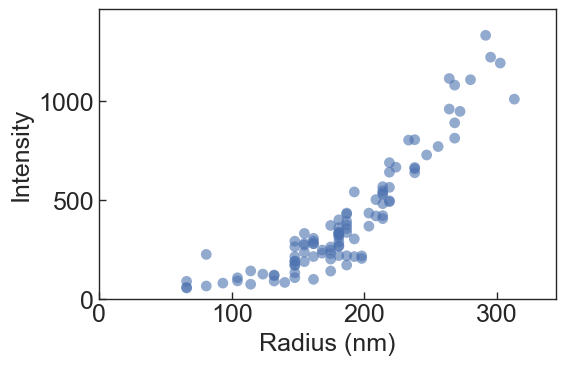

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import filedialog, Tk
import os

# Set seaborn style to match your preferences
sns.set(style="white", rc={"axes.linewidth": 1})
plt.rcParams['font.size'] = 18

def select_file(title):
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def match_and_plot():
    # Step 1: Select TrackMate CSV file
    print("Please select the TrackMate CSV file")
    trackmate_file = select_file("Select TrackMate CSV File")
    if not trackmate_file:
        print("No TrackMate file selected. Exiting.")
        return
    
    # Step 2: Select ilastik CSV file
    print("Please select the ilastik CSV file")
    ilastik_file = select_file("Select ilastik CSV File")
    if not ilastik_file:
        print("No ilastik file selected. Exiting.")
        return
    
    # Step 3: Read and process TrackMate data
    try:
        trackmate_data = pd.read_csv(trackmate_file)
        print("\nTrackMate columns found:", trackmate_data.columns.tolist())
        
        # Verify required columns exist
        trackmate_req = ['trackID', 'x', 'y', 't', 'meanIntensity']
        missing_track = [col for col in trackmate_req if col not in trackmate_data.columns]
        if missing_track:
            raise ValueError(f"Missing columns in TrackMate data: {missing_track}")
        
        # Filter for t=0 and get unique track IDs
        t0_trackmate = trackmate_data[trackmate_data['t'] == 0].copy()
        t0_trackmate.drop_duplicates(subset=['trackID'], inplace=True)
        print(f"Found {len(t0_trackmate)} unique tracks at t=0")
        
    except Exception as e:
        print(f"\nError reading TrackMate file: {str(e)}")
        return
    
    # Step 4: Read and process ilastik data
    try:
        ilastik_data = pd.read_csv(ilastik_file)
        print("\nilastik columns found:", ilastik_data.columns.tolist())
        
        # Verify required columns exist
        ilastik_req = ['center_x_pxl', 'center_y_pxl', 'frame', 'R_nm']
        missing_ilastik = [col for col in ilastik_req if col not in ilastik_data.columns]
        if missing_ilastik:
            raise ValueError(f"Missing columns in ilastik data: {missing_ilastik}")
        
        # Filter for frame=0
        frame0_ilastik = ilastik_data[ilastik_data['frame'] == 0].copy()
        print(f"Found {len(frame0_ilastik)} objects at frame=0")
        
    except Exception as e:
        print(f"\nError reading ilastik file: {str(e)}")
        return
    
    # Step 5: Match coordinates and collect data
    matched_data = []
    tolerance = 0.2  # Tight tolerance of 0.2 pixels
    print(f"\nMatching coordinates with tolerance = {tolerance} pixels...")
    
    for _, track_row in t0_trackmate.iterrows():
        try:
            x_track = float(track_row['x'])
            y_track = float(track_row['y'])
            track_id = track_row['trackID']
            
            # Calculate distances
            x_diff = abs(frame0_ilastik['center_x_pxl'] - x_track)
            y_diff = abs(frame0_ilastik['center_y_pxl'] - y_track)
            
            # Create mask
            mask = (x_diff <= tolerance) & (y_diff <= tolerance)
            matches = frame0_ilastik[mask]
            
            if len(matches) > 0:
                ilastik_row = matches.iloc[0]
                matched_data.append({
                    'track_id': track_id,
                    'x': x_track,
                    'y': y_track,
                    'radius_nm': float(ilastik_row['R_nm']),
                    'intensity': float(track_row['meanIntensity'])
                })
                
        except Exception as e:
            print(f"Error processing track {track_id}: {str(e)}")
            continue
    
    if not matched_data:
        print("\nNo matching coordinates found between the files with tolerance=0.2.")
        print("Possible solutions:")
        print("1. Increase tolerance value")
        print("2. Check if coordinate systems are aligned")
        print("3. Verify both files contain data at t=0/frame=0")
        return
    
    # Convert to DataFrame
    results = pd.DataFrame(matched_data)
    print(f"\nSuccessfully matched {len(results)} tracks")
    
    # Step 6: Plot intensity vs radius with new aesthetics
    plt.figure(figsize=(6, 4))
    
    # Create scatter plot with custom style
    ax = sns.scatterplot(
        data=results,
        x='radius_nm',
        y='intensity',
        color="#4C72B0",  # Using your preferred blue color
        alpha=0.6,
        edgecolor='none',
        s=60  # Marker size
    )
    
    # Set axis labels and title
    plt.xlabel('Radius (nm)', fontsize=18)
    plt.ylabel('Intensity', fontsize=18)
    # plt.title(f'Intensity vs Radius at t=0\n({len(results)} matches)', fontsize=16)
    
    # Apply custom axis and tick formatting
    ax.spines[:].set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    ax.set_axisbelow(False)
    
    # Set axis limits with padding
    plt.xlim(0, results['radius_nm'].max()*1.1)
    plt.ylim(0, results['intensity'].max()*1.1)
    
    # Save the plot
    output_dir = os.path.dirname(trackmate_file)
    plot_path = os.path.join(output_dir, 'intensity_vs_radius_tol0.2_styled.png')
    plt.tight_layout()
    plt.savefig(plot_path, format="png", bbox_inches="tight", dpi=600)
    print(f"\nStyled plot saved to: {plot_path}")
    
    # Save the matched data
    results_path = os.path.join(output_dir, 'matched_data_tol0.2.csv')
    results.to_csv(results_path, index=False)
    print(f"Matched data saved to: {results_path}")
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    match_and_plot()

## Intensity vs Radius linear fitting

Please select the TrackMate CSV file
Please select the ilastik CSV file

TrackMate columns found: ['spotID', 'trackID', 'QUALITY', 'x', 'y', 't', 'R', 'meanIntensity', 'medianIntensity', 'minIntensity', 'maxIntensity', 'totalIntensity', 'stdIntensity', 'contrast', 'SNR']
Found 141 unique tracks at t=0

ilastik columns found: ['frame', 'condensateID', 'contour_coord', 'center_x_pxl', 'center_y_pxl', 'area_um2', 'R_nm', 'mean_intensity', 'max_intensity', 'max_location', 'aspect_ratio', 'contour_solidity', 'contour_extent']
Found 127 objects at frame=0

Matching coordinates with tolerance = 0.2 pixels...

Successfully matched 103 tracks

Linear fit for radius ≥ 200 nm:
Slope: 7.8637
Intercept: -1163.9783
R-squared: 0.8605

Styled plot saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/reformatted/hops\intensity_vs_radius_tol0.2_styled.png
Matched data saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskelet

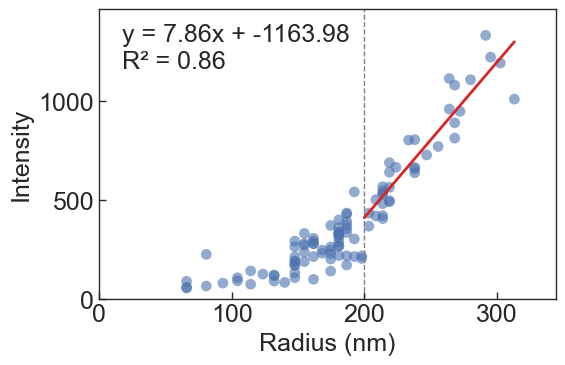

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tkinter import filedialog, Tk
import os
import numpy as np
from scipy.stats import linregress

# Set seaborn style to match your preferences
sns.set(style="white", rc={"axes.linewidth": 1})
plt.rcParams['font.size'] = 18

def select_file(title):
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def match_and_plot():
    # Step 1: Select TrackMate CSV file
    print("Please select the TrackMate CSV file")
    trackmate_file = select_file("Select TrackMate CSV File")
    if not trackmate_file:
        print("No TrackMate file selected. Exiting.")
        return
    
    # Step 2: Select ilastik CSV file
    print("Please select the ilastik CSV file")
    ilastik_file = select_file("Select ilastik CSV File")
    if not ilastik_file:
        print("No ilastik file selected. Exiting.")
        return
    
    # Step 3: Read and process TrackMate data
    try:
        trackmate_data = pd.read_csv(trackmate_file)
        print("\nTrackMate columns found:", trackmate_data.columns.tolist())
        
        # Verify required columns exist
        trackmate_req = ['trackID', 'x', 'y', 't', 'meanIntensity']
        missing_track = [col for col in trackmate_req if col not in trackmate_data.columns]
        if missing_track:
            raise ValueError(f"Missing columns in TrackMate data: {missing_track}")
        
        # Filter for t=0 and get unique track IDs
        t0_trackmate = trackmate_data[trackmate_data['t'] == 0].copy()
        t0_trackmate.drop_duplicates(subset=['trackID'], inplace=True)
        print(f"Found {len(t0_trackmate)} unique tracks at t=0")
        
    except Exception as e:
        print(f"\nError reading TrackMate file: {str(e)}")
        return
    
    # Step 4: Read and process ilastik data
    try:
        ilastik_data = pd.read_csv(ilastik_file)
        print("\nilastik columns found:", ilastik_data.columns.tolist())
        
        # Verify required columns exist
        ilastik_req = ['center_x_pxl', 'center_y_pxl', 'frame', 'R_nm']
        missing_ilastik = [col for col in ilastik_req if col not in ilastik_data.columns]
        if missing_ilastik:
            raise ValueError(f"Missing columns in ilastik data: {missing_ilastik}")
        
        # Filter for frame=0
        frame0_ilastik = ilastik_data[ilastik_data['frame'] == 0].copy()
        print(f"Found {len(frame0_ilastik)} objects at frame=0")
        
    except Exception as e:
        print(f"\nError reading ilastik file: {str(e)}")
        return
    
    # Step 5: Match coordinates and collect data
    matched_data = []
    tolerance = 0.2  # Tight tolerance of 0.2 pixels
    print(f"\nMatching coordinates with tolerance = {tolerance} pixels...")
    
    for _, track_row in t0_trackmate.iterrows():
        try:
            x_track = float(track_row['x'])
            y_track = float(track_row['y'])
            track_id = track_row['trackID']
            
            # Calculate distances
            x_diff = abs(frame0_ilastik['center_x_pxl'] - x_track)
            y_diff = abs(frame0_ilastik['center_y_pxl'] - y_track)
            
            # Create mask
            mask = (x_diff <= tolerance) & (y_diff <= tolerance)
            matches = frame0_ilastik[mask]
            
            if len(matches) > 0:
                ilastik_row = matches.iloc[0]
                matched_data.append({
                    'track_id': track_id,
                    'x': x_track,
                    'y': y_track,
                    'radius_nm': float(ilastik_row['R_nm']),
                    'intensity': float(track_row['meanIntensity'])
                })
                
        except Exception as e:
            print(f"Error processing track {track_id}: {str(e)}")
            continue
    
    if not matched_data:
        print("\nNo matching coordinates found between the files with tolerance=0.2.")
        print("Possible solutions:")
        print("1. Increase tolerance value")
        print("2. Check if coordinate systems are aligned")
        print("3. Verify both files contain data at t=0/frame=0")
        return
    
    # Convert to DataFrame
    results = pd.DataFrame(matched_data)
    print(f"\nSuccessfully matched {len(results)} tracks")
    
    # Step 6: Plot intensity vs radius with new aesthetics
    plt.figure(figsize=(6, 4))
    
    # Create scatter plot with custom style
    ax = sns.scatterplot(
        data=results,
        x='radius_nm',
        y='intensity',
        color="#4C72B0",  # Using your preferred blue color
        alpha=0.6,
        edgecolor='none',
        s=60  # Marker size
    )
    
    # Add vertical line at x = 200 nm
    plt.axvline(x=200, color='gray', linestyle='--', linewidth=1)
    
    # Fit and plot linear regression for radius ≥ 200 nm
    large_radii = results[results['radius_nm'] >= 200]
    if len(large_radii) >= 2:  # Need at least 2 points for linear fit
        x_fit = large_radii['radius_nm']
        y_fit = large_radii['intensity']
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
        
        # Create line points
        x_line = np.linspace(200, results['radius_nm'].max(), 100)
        y_line = slope * x_line + intercept
        
        # Plot the fitted line
        plt.plot(x_line, y_line, color='#D62728', linestyle='-', linewidth=2)
        
        # Add equation text in top LEFT with no frame
        equation_text = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}'
        plt.text(0.05, 0.95, equation_text, 
                transform=ax.transAxes, 
                ha='left', 
                va='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
        print(f"\nLinear fit for radius ≥ 200 nm:")
        print(f"Slope: {slope:.4f}")
        print(f"Intercept: {intercept:.4f}")
        print(f"R-squared: {r_value**2:.4f}")
    
    # Set axis labels and title
    plt.xlabel('Radius (nm)', fontsize=18)
    plt.ylabel('Intensity', fontsize=18)
    
    # Apply custom axis and tick formatting
    ax.spines[:].set_linewidth(1)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    ax.set_axisbelow(False)
    
    # Set axis limits with padding
    plt.xlim(0, results['radius_nm'].max()*1.1)
    plt.ylim(0, results['intensity'].max()*1.1)
    
    # Save the plot
    output_dir = os.path.dirname(trackmate_file)
    plot_path = os.path.join(output_dir, 'intensity_vs_radius_tol0.2_styled.png')
    plt.tight_layout()
    plt.savefig(plot_path, format="png", bbox_inches="tight", dpi=600)
    print(f"\nStyled plot saved to: {plot_path}")
    
    # Save the matched data
    results_path = os.path.join(output_dir, 'matched_data_tol0.2.csv')
    results.to_csv(results_path, index=False)
    print(f"Matched data saved to: {results_path}")
    
    # Show the plot
    plt.show()

if __name__ == "__main__":
    match_and_plot()

## Theoretical intensity vs experimental intensity table

In [ ]:
import pandas as pd
import numpy as np
import os
from tkinter import filedialog, Tk

def select_file(title):
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def get_random_condensate(df, intensity_range, radius_range, max_attempts=100):
    """Select a random condensate matching given intensity and radius criteria"""
    for _ in range(max_attempts):
        sample = df.sample(1)
        if (intensity_range[0] <= sample['intensity'].values[0] <= intensity_range[1] and
            radius_range[0] <= sample['radius_nm'].values[0] <= radius_range[1]):
            return sample
    return None

def calculate_theoretical_D(radius_nm, viscosity_mPas=77, temperature_K=335):
    """Calculate theoretical D using Stokes-Einstein equation with ACTUAL radius"""
    kB = 1.380649e-23  # Boltzmann constant (J/K)
    radius_m = radius_nm * 1e-9
    viscosity_Pas = viscosity_mPas * 1e-3
    D = (kB * temperature_K) / (6 * np.pi * viscosity_Pas * radius_m)  # in m²/s
    return D * 1e12  # convert to µm²/s

# Load the matched data file
matched_data_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\hops\matched_data_tol0.2.csv"
matched_df = pd.read_csv(matched_data_path)

# Load the SPT results file
spt_results_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\hops\SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-1-bandpass-even_reformatted.csv"
spt_df = pd.read_csv(spt_results_path)

# Define selection criteria
selection_criteria = [
    {'intensity': (0, 200), 'radius': (0, 100)},
    {'intensity': (400, 600), 'radius': (100, 250)},
    {'intensity': (800, 1000), 'radius': (250, 300)},
    {'intensity': (1000, np.inf), 'radius': (300, np.inf)}
]

# Create results table
results = []

for criteria in selection_criteria:
    found = False
    attempts = 0
    
    while not found and attempts < 100:
        condensate = get_random_condensate(
            matched_df,
            criteria['intensity'],
            criteria['radius']
        )
        
        if condensate is None:
            attempts += 1
            continue
            
        track_id = condensate['track_id'].values[0]
        actual_radius = condensate['radius_nm'].values[0]  # Get ACTUAL radius
        
        # Find matching track in SPT results (R² > 0.6)
        spt_match = spt_df[(spt_df['trackID'] == track_id) & 
                          (spt_df['linear_fit_R2'] > 0.6)]
        
        if not spt_match.empty:
            exp_D = spt_match['linear_fit_D_um2s'].values[0]
            theo_D = calculate_theoretical_D(actual_radius)  # Use ACTUAL radius now!
            
            results.append({
                'trackID': track_id,
                'Intensity': condensate['intensity'].values[0],
                'Radius (nm)': actual_radius,
                'Theoretical D (µm²/s)': theo_D,
                'Experimental D (µm²/s)': exp_D,
                'R²': spt_match['linear_fit_R2'].values[0]
            })
            found = True
        else:
            attempts += 1

# Create and display the results table
results_df = pd.DataFrame(results)
print("\nSelected Condensates with Diffusion Coefficients:")
print(results_df.to_string(index=False, float_format="%.6f"))  # 6 decimal places for D

# Save the table
output_path = os.path.join(os.path.dirname(matched_data_path), 'condensate_comparison_table_ACTUAL_RADIUS.csv')
results_df.to_csv(output_path, index=False)
print(f"\nTable saved to: {output_path}")


Selected Condensates with Diffusion Coefficients:
   trackID   Intensity  Radius (nm)  Theoretical D (µm²/s)  Experimental D (µm²/s)       R²
 94.000000   63.567568    80.845631               0.039417                0.000232 0.996189
 97.000000  427.108108   186.704987               0.017068                0.000189 0.985122
 93.000000  946.432432   272.166950               0.011708                0.000319 0.997629
120.000000 1008.324324   313.113782               0.010177                0.000118 0.974807

Table saved to: Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\hops\condensate_comparison_table_ACTUAL_RADIUS.csv


## Theoretical vs Experimental D for GEMs

In [26]:
import pandas as pd
import numpy as np
import os
from tkinter import filedialog, Tk

def select_file(title):
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_path

def calculate_theoretical_D(radius_nm, viscosity_mPas=77, temperature_K=335):
    """Calculate theoretical D using Stokes-Einstein equation"""
    kB = 1.380649e-23  # Boltzmann constant (J/K)
    radius_m = radius_nm * 1e-9
    viscosity_Pas = viscosity_mPas * 1e-3
    D = (kB * temperature_K) / (6 * np.pi * viscosity_Pas * radius_m)  # in m²/s
    return D * 1e12  # convert to µm²/s

# Load the GEM SPT results file
spt_results_path = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\gem\SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-1-bandpass-odd_reformatted.csv"
spt_df = pd.read_csv(spt_results_path)

# Filter for tracks with good R² (>0.6)
filtered_df = spt_df[spt_df['linear_fit_R2'] > 0.6]

# Select 4 random tracks
if len(filtered_df) >= 4:
    random_tracks = filtered_df.sample(4)
else:
    random_tracks = filtered_df.sample(len(filtered_df))
    print(f"Warning: Only found {len(filtered_df)} tracks with R² > 0.6")

# Create results table
results = []

for _, row in random_tracks.iterrows():
    theo_D = calculate_theoretical_D(40)  # Fixed 40 nm radius for GEMs
    
    results.append({
        'trackID': row['trackID'],
        'Radius (nm)': 40,  # Fixed value
        'Theoretical D (µm²/s)': theo_D,
        'Experimental D (µm²/s)': row['linear_fit_D_um2s'],
        'R²': row['linear_fit_R2']
    })

# Create and display the results table
results_df = pd.DataFrame(results)
print("\nSelected GEM Tracks with Diffusion Coefficients:")
print(results_df.to_string(index=False, float_format="%.6f"))

# Save the table
output_dir = os.path.dirname(spt_results_path)
output_path = os.path.join(output_dir, 'GEM_diffusion_comparison_table.csv')
results_df.to_csv(output_path, index=False)
print(f"\nTable saved to: {output_path}")


Selected GEM Tracks with Diffusion Coefficients:
    trackID  Radius (nm)  Theoretical D (µm²/s)  Experimental D (µm²/s)       R²
3965.000000           40               0.079667                0.136530 0.916665
3701.000000           40               0.079667                0.017967 0.771960
2216.000000           40               0.079667                0.022489 0.895468
9205.000000           40               0.079667                0.014519 0.978485

Table saved to: Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\GEM tracking\GEM_HOPS Cotracking\reformatted\gem\GEM_diffusion_comparison_table.csv


## Intensity vs Radius plot for HOPS condensates using multiple files

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os
from pathlib import Path
from tkinter import filedialog, Tk
import ast

# Set plotting style
sns.set(style="white", rc={"axes.linewidth": 1})
plt.rcParams['font.size'] = 18

def select_files(title="Select Files", multiple=True):
    """Select files using file dialog"""
    root = Tk()
    root.withdraw()
    if multiple:
        file_paths = filedialog.askopenfilenames(title=title)
    else:
        file_paths = filedialog.askopenfilename(title=title)
    root.destroy()
    return file_paths

In [11]:
# Step 1: Load ilastik files
print("Step 1: Loading ilastik files...")

ilastik_files = select_files("Select ilastik CSV files", multiple=True)

if not ilastik_files:
    print("No files selected.")
    exit()

all_data = []

for file_path in ilastik_files:
    print(f"Loading: {Path(file_path).name}")
    
    try:
        df = pd.read_csv(file_path)
        
        # Check for required columns
        if 'R_nm' not in df.columns:
            print(f"Warning: No R_nm column in {Path(file_path).name}")
            continue
            
        # Find intensity column
        intensity_cols = [col for col in df.columns if 'intensity' in col.lower()]
        if not intensity_cols:
            print(f"Warning: No intensity column in {Path(file_path).name}")
            continue
            
        if len(intensity_cols) > 0:
            df = df.rename(columns={intensity_cols[0]: 'mean_intensity'})
        
        # Filter for frame 0 if frame column exists
        if 'frame' in df.columns:
            df = df[df['frame'] == 0]
        
        df['source_file'] = Path(file_path).name
        all_data.append(df)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        continue

if not all_data:
    print("No valid data loaded.")
    exit()

combined_ilastik = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(combined_ilastik)} data points from {len(all_data)} files")

output_dir = os.path.dirname(ilastik_files[0])

Step 1: Loading ilastik files...
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-1.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-2.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-3.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-4.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-5.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-6.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-7.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-8.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-1.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-2.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-3.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-4.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-5.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-6.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-7.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-8.csv
Loading: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-9.csv
Loading: 40nmGE


Step 2: Creating calibration plot...
Calibration plot saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/ilastik_HOPS_radius/csv_files\calibration_intensity_vs_radius.png


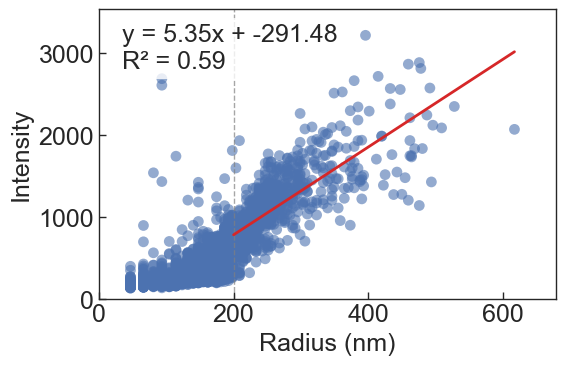

In [14]:
# Step 2: Create calibration plot
print("\nStep 2: Creating calibration plot...")

plt.figure(figsize=(6, 4))

# Plot all data points
ax = sns.scatterplot(
    data=combined_ilastik,
    x='R_nm',
    y='mean_intensity',
    color="#4C72B0",
    alpha=0.6,
    edgecolor='none',
    s=60
)

plt.axvline(x=200, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Fit linear regression for radius ≥ 200 nm
large_radii = combined_ilastik[combined_ilastik['R_nm'] >= 200]

if len(large_radii) >= 2:
    x_fit = large_radii['R_nm']
    y_fit = large_radii['mean_intensity']
    
    slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)
    
    x_line = np.linspace(200, combined_ilastik['R_nm'].max(), 100)
    y_line = slope * x_line + intercept
    
    plt.plot(x_line, y_line, color='#D62728', linestyle='-', linewidth=2)
    
    equation_text = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}'
    plt.text(0.05, 0.95, equation_text,
             transform=ax.transAxes,
             ha='left', va='top',
             fontsize=18,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.xlabel('Radius (nm)', fontsize=18)
plt.ylabel('Intensity', fontsize=18)

ax.spines[:].set_linewidth(1)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
ax.set_axisbelow(False)

plt.xlim(0, combined_ilastik['R_nm'].max()*1.1)
plt.ylim(0, combined_ilastik['mean_intensity'].max()*1.1)

plt.tight_layout()

calibration_plot_path = os.path.join(output_dir, 'calibration_intensity_vs_radius.png')
plt.savefig(calibration_plot_path, format="png", bbox_inches="tight", dpi=600)
print(f"Calibration plot saved to: {calibration_plot_path}")

plt.show()

In [15]:
# Step 3: Identify condensates with predicted radius ≤ 100 nm
print("\nStep 3: Identifying condensates with predicted radius ≤ 100 nm...")

if 'slope' not in locals():
    print("Error: Calibration parameters not found.")
    exit()

combined_ilastik['predicted_radius'] = (combined_ilastik['mean_intensity'] - intercept) / slope

target_condensates = combined_ilastik[combined_ilastik['predicted_radius'] <= 100].copy()

print(f"Found {len(target_condensates)} condensates with predicted radius ≤ 100 nm")

if len(target_condensates) == 0:
    print("No condensates found.")
    exit()

target_path = os.path.join(output_dir, 'target_condensates_le_100nm.csv')
target_condensates.to_csv(target_path, index=False)
print(f"Target condensates saved to: {target_path}")


Step 3: Identifying condensates with predicted radius ≤ 100 nm...
Found 933 condensates with predicted radius ≤ 100 nm
Target condensates saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/ilastik_HOPS_radius/csv_files\target_condensates_le_100nm.csv


In [18]:
# Step 4: Match with TrackMate files
print("\nStep 4: Matching with TrackMate files...")

print("Select HOPS TrackMate CSV files")
trackmate_files = select_files("Select HOPS TrackMate CSV files", multiple=True)

if not trackmate_files:
    print("No files selected.")
    exit()

trackmate_dict = {}
for trackmate_file in trackmate_files:
    base_name = Path(trackmate_file).stem
    # Clean the filename for matching with ilastik files
    clean_name = base_name.replace('SPT_results_AIO-', '').replace('_reformatted', '')
    trackmate_dict[clean_name] = trackmate_file
    print(f"Loaded: {base_name} -> Key: {clean_name}")

diffusion_data = []
matched_count = 0
um_per_pixel = 0.117

print(f"\nNumber of target condensates: {len(target_condensates)}")

for idx, condensate in target_condensates.iterrows():
    source_file = condensate['source_file']
    base_name = Path(source_file).stem
    
    # Clean ilastik filename to match TrackMate key
    clean_ilastik_name = base_name.replace('condensates_AIO-', '')
    
    # Find matching TrackMate file
    trackmate_file = None
    matched_key = None
    for key in trackmate_dict.keys():
        if key in clean_ilastik_name or clean_ilastik_name in key:
            trackmate_file = trackmate_dict[key]
            matched_key = key
            break
    
    if trackmate_file is None:
        continue
    
    try:
        trackmate_df = pd.read_csv(trackmate_file)
        
        # Filter for good R²
        if 'linear_fit_R2' in trackmate_df.columns:
            trackmate_df = trackmate_df[trackmate_df['linear_fit_R2'] > 0.6]
        
        if 'linear_fit_D_um2s' not in trackmate_df.columns:
            continue
        
        # Get ilastik coordinates (in pixels) and convert to micrometers
        if 'center_x_pxl' in condensate.index and 'center_y_pxl' in condensate.index:
            x_cond = condensate['center_x_pxl'] * um_per_pixel
            y_cond = condensate['center_y_pxl'] * um_per_pixel
        else:
            # Try to find coordinate columns dynamically
            x_cols = [col for col in condensate.index if 'x' in col.lower() and 'center' in col.lower()]
            y_cols = [col for col in condensate.index if 'y' in col.lower() and 'center' in col.lower()]
            if not x_cols or not y_cols:
                continue
            x_cond = condensate[x_cols[0]] * um_per_pixel
            y_cond = condensate[y_cols[0]] * um_per_pixel
        
        # Parse TrackMate coordinates from list strings
        for track_idx, track_row in trackmate_df.iterrows():
            try:
                # Parse the list_of_x string to get the first position (t=0)
                if 'list_of_x' in track_row and 'list_of_y' in track_row:
                    # Convert string representation of list to actual list
                    x_list_str = track_row['list_of_x']
                    y_list_str = track_row['list_of_y']
                    
                    # Parse the list string
                    if isinstance(x_list_str, str) and x_list_str.startswith('['):
                        x_list = ast.literal_eval(x_list_str)
                        y_list = ast.literal_eval(y_list_str)
                    else:
                        continue
                    
                    if len(x_list) == 0 or len(y_list) == 0:
                        continue
                    
                    # Get first position (t=0) and convert from pixels to micrometers
                    x_track = float(x_list[0]) * um_per_pixel
                    y_track = float(y_list[0]) * um_per_pixel
                    
                    # Calculate distance
                    distance = np.sqrt((x_track - float(x_cond))**2 + (y_track - float(y_cond))**2)
                    
                    if distance <= 0.3:  # 0.3 µm tolerance
                        diffusion = track_row['linear_fit_D_um2s']
                        track_id = track_row['trackID']
                        
                        diffusion_data.append({
                            'source_file': source_file,
                            'trackmate_file': matched_key,
                            'track_id': track_id,
                            'diffusion_coefficient_um2s': diffusion,
                            'predicted_radius_nm': condensate['predicted_radius'],
                            'intensity': condensate['mean_intensity'],
                            'match_distance_um': distance,
                            'ilastik_x_um': x_cond,
                            'ilastik_y_um': y_cond,
                            'trackmate_x_um': x_track,
                            'trackmate_y_um': y_track
                        })
                        
                        matched_count += 1
                        
                        if matched_count % 10 == 0:
                            print(f"Matched {matched_count} condensates...")
                        
                        break  # Found a match, move to next condensate
                        
            except Exception as e:
                # Skip this track if there's an error parsing coordinates
                continue
                
    except Exception as e:
        print(f"Error processing file {trackmate_file}: {str(e)}")
        continue

print(f"\nMatched {matched_count} condensates")

if diffusion_data:
    hops_diffusion_df = pd.DataFrame(diffusion_data)
    hops_diffusion_path = os.path.join(output_dir, 'hops_le_100nm_diffusion.csv')
    hops_diffusion_df.to_csv(hops_diffusion_path, index=False)
    print(f"HOPS diffusion data saved to: {hops_diffusion_path}")
    
    # Print summary
    print(f"\n=== MATCHING SUMMARY ===")
    print(f"Total matches: {matched_count}")
    print(f"Average diffusion coefficient: {hops_diffusion_df['diffusion_coefficient_um2s'].mean():.6f} µm²/s")
    print(f"Average match distance: {hops_diffusion_df['match_distance_um'].mean():.3f} µm")
    print(f"Files with matches: {hops_diffusion_df['source_file'].nunique()}")
    
    # Show first few matches
    print(f"\nFirst 5 matches:")
    print(hops_diffusion_df[['track_id', 'predicted_radius_nm', 'diffusion_coefficient_um2s', 'match_distance_um']].head())
else:
    print("No diffusion coefficients found")
    hops_diffusion_df = pd.DataFrame()


Step 4: Matching with TrackMate files...
Select HOPS TrackMate CSV files
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-4 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-4
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-3 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-3
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-2 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-2
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-1 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep3-FOV-1
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-9 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-9
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-8 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-8
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-7 -> Key: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-7
Loaded: 40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-6 -> Key: 40nmGEM-RFPDCP

In [19]:
# Step 5: Load GEM diffusion data
print("\nStep 5: Loading GEM diffusion data...")

print("Select GEM TrackMate CSV files")
gem_files = select_files("Select GEM TrackMate CSV files", multiple=True)

gem_diffusion_data = []

for gem_file in gem_files:
    try:
        gem_df = pd.read_csv(gem_file)
        
        if 'linear_fit_D_um2s' in gem_df.columns:
            if 'linear_fit_R2' in gem_df.columns:
                gem_df = gem_df[gem_df['linear_fit_R2'] > 0.6]
            
            for _, row in gem_df.iterrows():
                gem_diffusion_data.append({
                    'source_file': Path(gem_file).name,
                    'diffusion_coefficient_um2s': row['linear_fit_D_um2s']
                })
            
            print(f"Loaded {len(gem_df)} tracks from {Path(gem_file).name}")
            
    except Exception as e:
        print(f"Error: {str(e)}")
        continue

if gem_diffusion_data:
    gem_diffusion_df = pd.DataFrame(gem_diffusion_data)
    gem_diffusion_df['type'] = 'GEM'
    
    gem_diffusion_path = os.path.join(output_dir, 'gem_diffusion.csv')
    gem_diffusion_df.to_csv(gem_diffusion_path, index=False)
    print(f"Loaded {len(gem_diffusion_df)} GEM diffusion coefficients")
else:
    print("No GEM data loaded")
    gem_diffusion_df = pd.DataFrame()


Step 5: Loading GEM diffusion data...
Select GEM TrackMate CSV files
Loaded 2825 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-1-bandpass-odd_reformatted.csv
Loaded 14001 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-2-bandpass-odd_modified_reformatted.csv
Loaded 8656 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-4-bandpass-odd_modified_reformatted.csv
Loaded 11722 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-5-bandpass-odd_modified_reformatted.csv
Loaded 5484 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-6-bandpass-odd_modified_reformatted.csv
Loaded 11280 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep1-FOV-8-bandpass-odd_modified_reformatted.csv
Loaded 13861 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-2-bandpass-odd_modified_reformatted.csv
Loaded 7297 tracks from SPT_results_AIO-40nmGEM-RFPDCP1A-48h-2x-20ms-rep2-FOV-4-bandpass-odd_modified_reforma

In [20]:
# Step 6: Prepare combined data for histogram
print("\nStep 6: Preparing data for histogram...")

# Prepare HOPS data
if not hops_diffusion_df.empty:
    hops_valid = hops_diffusion_df[hops_diffusion_df['diffusion_coefficient_um2s'] > 0].copy()
    hops_for_hist = hops_valid[['diffusion_coefficient_um2s']].copy()
    hops_for_hist['type'] = 'HOPS (≤100 nm)'
    print(f"Valid HOPS tracks: {len(hops_for_hist)}")
else:
    hops_for_hist = pd.DataFrame()

# Prepare GEM data
if not gem_diffusion_df.empty:
    gem_valid = gem_diffusion_df[gem_diffusion_df['diffusion_coefficient_um2s'] > 0].copy()
    gem_for_hist = gem_valid[['diffusion_coefficient_um2s', 'type']].copy()
    print(f"Valid GEM tracks: {len(gem_for_hist)}")
else:
    gem_for_hist = pd.DataFrame()

# Combine
if not hops_for_hist.empty and not gem_for_hist.empty:
    combined_diffusion = pd.concat([hops_for_hist, gem_for_hist], ignore_index=True)
    print(f"Total tracks for histogram: {len(combined_diffusion)}")
    
    combined_path = os.path.join(output_dir, 'combined_diffusion_data.csv')
    combined_diffusion.to_csv(combined_path, index=False)
    print(f"Combined data saved to: {combined_path}")
else:
    print("Not enough data for histogram")
    combined_diffusion = pd.DataFrame()


Step 6: Preparing data for histogram...
Valid HOPS tracks: 365
Valid GEM tracks: 159532
Total tracks for histogram: 159897
Combined data saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/ilastik_HOPS_radius/csv_files\combined_diffusion_data.csv


In [ ]:
# Step 7: Plot histogram
print("\nStep 7: Plotting histogram...")

if not combined_diffusion.empty:
    combined_diffusion['logD'] = np.log10(combined_diffusion['diffusion_coefficient_um2s'])
    
    color_dict = {"GEM": "#DD8452", "HOPS (≤100 nm)": "#4C72B0"}
    
    plt.figure(figsize=(6, 4))
    
    ax = sns.histplot(
        data=combined_diffusion,
        x='logD',
        hue="type",
        bins=30,
        stat="probability",
        common_norm=False,
        binrange=(-5, 1.1),
        lw=2,
        element="step",
        fill=True,
        alpha=0.4,
        palette=color_dict,
        hue_order=["GEM", "HOPS (≤100 nm)"]
    )
    
    if ax.legend_:
        handles = ax.legend_.legendHandles[::-1]
        # Updated legend labels - changed ≈ to ~
        ax.legend(handles, ['HOPS (≤100 nm)', 'GEM (~40 nm)'], fontsize=18)
    
    legend = ax.get_legend()
    if legend:
        legend.set_title(None)
        legend.get_frame().set_visible(False)
    
    n_hops = len(hops_for_hist)
    n_gem = len(gem_for_hist)
    
    plt.text(-4.95, 0.245, r"N$_{GEM}$=" + f"{n_gem:,}", fontdict={"fontsize": 18})
    plt.text(-4.95, 0.21, r"N$_{HOPS}$=" + f"{n_hops:,}", fontdict={"fontsize": 18})
    
    plt.xlim(-5, 1.1)
    plt.ylim(0,0.29)
    plt.xlabel('log(D [$\mu m^2/s$])', fontsize=18)
    plt.ylabel("Probability", fontsize=18)
    
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    plt.gca().set_axisbelow(False)
    
    plt.tight_layout()
    
    histo_path = os.path.join(output_dir, 'diffusion_histogram.png')
    plt.savefig(histo_path, format="png", bbox_inches="tight", dpi=600)
    print(f"Histogram saved to: {histo_path}")
    
    plt.show()
else:
    print("No data to plot")


Step 7: Plotting histogram...


c:\Users\bisal\.conda\envs\spt-simplified-20240126\lib\site-packages\seaborn\_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bisal\.conda\envs\spt-simplified-20240126\lib\site-packages\seaborn\_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bisal\.conda\envs\spt-simplified-20240126\lib\site-packages\seaborn\_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

Histogram saved to: Z:/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/GEM tracking/GEM_HOPS Cotracking/ilastik_HOPS_radius/csv_files\diffusion_histogram.png


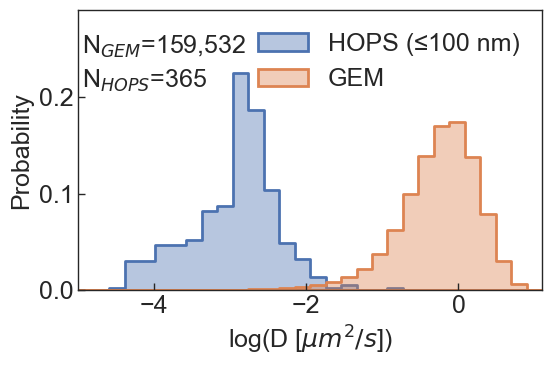

In [41]:
# Step 7: Plot histogram
print("\nStep 7: Plotting histogram...")

if not combined_diffusion.empty:
    combined_diffusion['logD'] = np.log10(combined_diffusion['diffusion_coefficient_um2s'])
    
    color_dict = {"GEM": "#DD8452", "HOPS (≤100 nm)": "#4C72B0"}
    
    plt.figure(figsize=(6, 4))
    
    ax = sns.histplot(
        data=combined_diffusion,
        x='logD',
        hue="type",
        bins=30,
        stat="probability",
        common_norm=False,
        binrange=(-5, 1.1),
        lw=2,
        element="step",
        fill=True,
        alpha=0.4,
        palette=color_dict,
        hue_order=["GEM", "HOPS (≤100 nm)"]
    )
    
    if ax.legend_:
        handles = ax.legend_.legendHandles[::-1]
        ax.legend(handles, ['HOPS (≤100 nm)', 'GEM'], fontsize=18)
    
    legend = ax.get_legend()
    if legend:
        legend.set_title(None)
        legend.get_frame().set_visible(False)
    
    n_hops = len(hops_for_hist)
    n_gem = len(gem_for_hist)
    
    plt.text(-4.95, 0.245, r"N$_{GEM}$=" + f"{n_gem:,}", fontdict={"fontsize": 18})
    plt.text(-4.95, 0.21, r"N$_{HOPS}$=" + f"{n_hops:,}", fontdict={"fontsize": 18})
    
    plt.xlim(-5, 1.1)
    plt.ylim(0,0.29)
    plt.xlabel('log(D [$\mu m^2/s$])', fontsize=18)
    plt.ylabel("Probability", fontsize=18)
    
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=18,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    plt.gca().set_axisbelow(False)
    
    plt.tight_layout()
    
    histo_path = os.path.join(output_dir, 'diffusion_histogram.png')
    plt.savefig(histo_path, format="png", bbox_inches="tight", dpi=600)
    print(f"Histogram saved to: {histo_path}")
    
    plt.show()
else:
    print("No data to plot")